# Word Cloud & Keyword Analysis (YouTube Titles)

โน้ตบุ๊กนี้ช่วยสร้าง **Word Cloud, Top Keywords และ Bigram Analysis** จากคอลัมน์ `Title` ของไฟล์ CSV ที่ดึงมาจาก YouTube (เช่น โหนกระแส)

รองรับภาษาไทยโดยใช้ `pythainlp` และฟอนต์ไทย เช่น TH Sarabun, Noto Sans Thai, Leelawadee


##  ขั้นที่ 1 — ติดตั้งไลบรารี (ทำใน venv ของโปรเจกต์)
```bash
python -m pip install wordcloud pythainlp pandas matplotlib
```
หากไม่มีฟอนต์ไทยในเครื่อง → ติดตั้งฟอนต์ (เช่น TH Sarabun New) และแก้ `font_path` 
ในโค้ดด้านล่าง

In [ ]:
pip install wordcloud pythainlp pandas matplotlib

## ขั้นที่ 2 — โหลดข้อมูล & หา Font ภาษาไทย

In [1]:
import pandas as pd
from matplotlib import font_manager

CSV_PATH = "youtube_videos.csv"  # ปรับชื่อไฟล์ตามจริง
df = pd.read_csv(CSV_PATH, encoding="utf-8-sig")
df.head()

# ----- หา font ภาษาไทย -----
def find_thai_font():
    candidates = ["Sarabun", "TH Sarabun", "Noto Sans Thai", "Leelawadee", "Tahoma", "K2D"]
    for fpath in font_manager.findSystemFonts():
        lower = fpath.lower()
        if any(k.lower().replace(" ", "") in lower.replace(" ", "") for k in candidates):
            return fpath
    return None  # ถ้าไม่มี ให้ระบุ path เอง

THAI_FONT = find_thai_font()
print("Thai font:", THAI_FONT)


Thai font: C:\Windows\Fonts\THSarabun Bold.ttf


## ขั้นที่ 3 — ทำความสะอาดข้อความ & ตัดคำภาษาไทย

In [ ]:
import re
from collections import Counter
from pythainlp import word_tokenize
from pythainlp.corpus import thai_stopwords

titles = df["Title"].dropna().astype(str).tolist()

# --- Normalizer helpers ---
PUNCT_TAIL = r"\.\,、，。!！\?？:：;；·•\-–—"   # trailing punctuation to strip
ZW = r"[\u200b\ufeff]"                          # zero-width
EMOJI_RE = re.compile(r"[\U0001F300-\U0001FAFF\U00002700-\U000027BF]")

def normalize_token(w: str) -> str:
    """Lowercase, strip hashtags/@, zero-width, trailing punct, and emojis."""
    w = w.strip()
    w = re.sub(r"^[#@]+", "", w)           # #โหนกระแส / @โหนกระแส -> โหนกระแส
    w = re.sub(ZW, "", w)                  # remove zero-width
    w = re.sub(EMOJI_RE, "", w)            # remove common emojis
    w = re.sub(f"[{PUNCT_TAIL}]+$", "", w) # strip trailing punctuation variants
    return w.casefold()                    # case-insensitive

# --- Stopwords ---
stop_th = set(map(normalize_token, thai_stopwords()))
custom_stop_raw = {
    "โหน", "กระแส","ล่าสุด","เต็ม","คลิป","ep","ตอน","สัมภาษณ์","เปิดใจ",
    "รายการ","พิเศษ","ประเด็น","live","breaking","highlight","คลิปเต็ม",
    # add more if needed: "ด่วน","exclusive","official"
}
channel_name_core = "โหนกระแส"

custom_stop = set(map(normalize_token, custom_stop_raw))
stop_all = stop_th | custom_stop



# --- Cleaning ---
def clean_text(s: str) -> str:
    s = s.strip()
    s = re.sub(r"http\S+", " ", s)     # remove URLs
    s = re.sub(ZW, " ", s)             # remove zero-width
    # keep punctuation minimal so Thai tokenization isn't harmed
    s = re.sub(r"[(){}\[\]\|*\"'`~^=+<>@#$%&_]", " ", s)
    return s

# --- Tokenize & filter ---
tokens = []
NUMLIKE_RE = re.compile(r"^[0-9]+([.:/\-][0-9]+)*$")  # numbers, times, dates

for t in titles:
    t = clean_text(t)
    toks = word_tokenize(t, engine="newmm", keep_whitespace=False)
    for w in toks:
        nw = normalize_token(w)
        if len(nw) < 2:               # very short tokens
            continue
        if NUMLIKE_RE.match(nw):      # numbers/time/date-like strings
            continue
        if nw in stop_all:            # remove channel name & common filler
            continue
        tokens.append(nw)

freq = Counter(tokens)
print("Sample tokens:", tokens[:30])
print("Unique tokens:", len(freq))


Sample tokens: ['เลือก', 'ไหม', 'ซ้าย', 'เจ็บ', 'ขวา', 'ปวด', 'วัดใจ', 'พรรค', 'ปช', 'เลือก', 'นั่ง', 'นายกฯ', '.2008', 'ก.ย', 'วัด', 'พระ', 'บาท', 'น้ำพุ', 'หมอ', 'บี', 'สม', 'ปอง', 'นคร', 'ไธสง', 'กัมพูชา', 'จอม', 'พลัง', 'ส.ค', 'ลุ้น', 'ระทึก']
Unique tokens: 662


## ขั้นที่ 4 — Word Cloud + Top Keywords

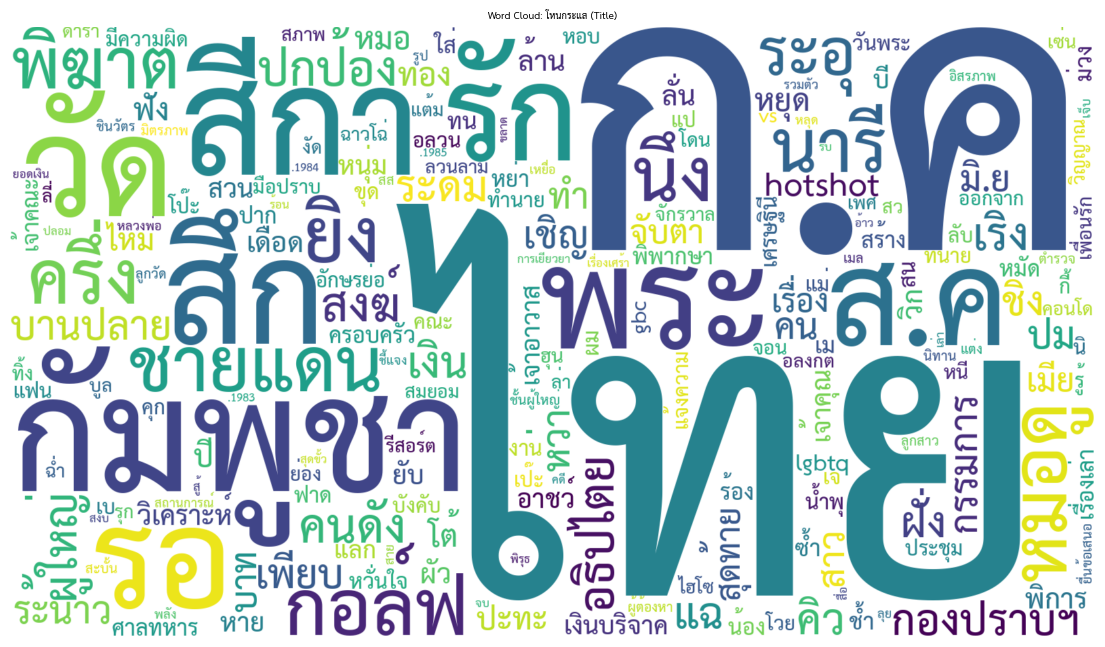

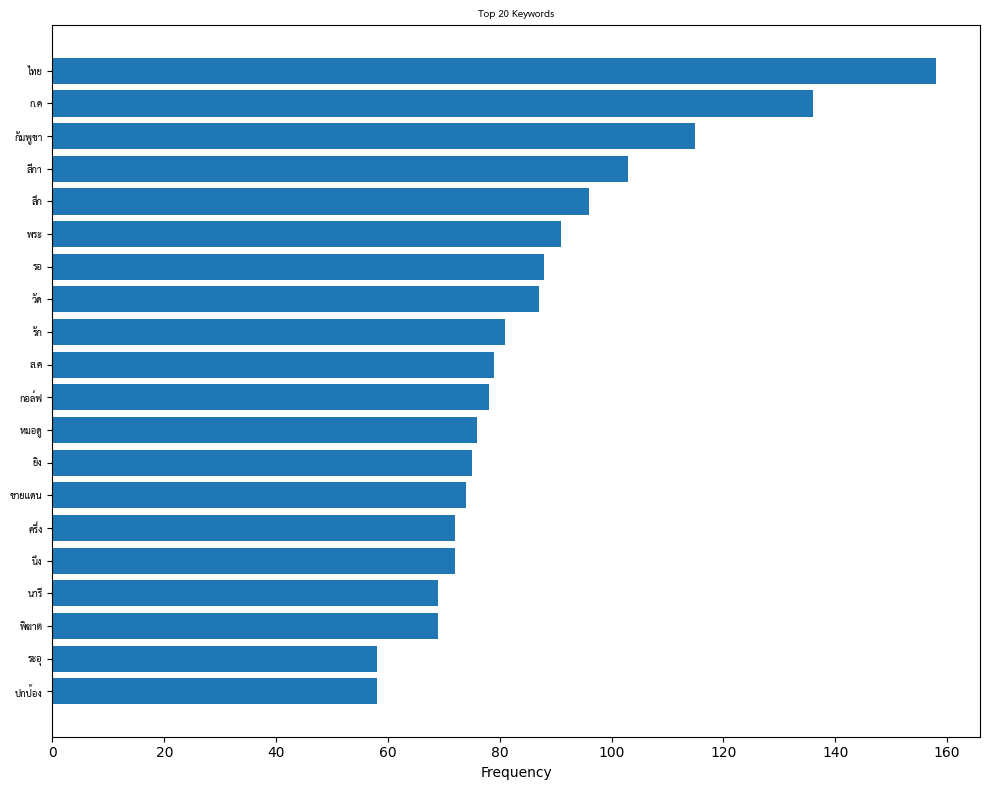

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# ----- Word Cloud -----
wc = WordCloud(
    font_path=THAI_FONT,
    width=1600, height=900,
    background_color="white",
    collocations=False
)
wc.generate_from_frequencies(freq)

plt.figure(figsize=(14,8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud: โหนกระแส (Title)", fontproperties=font_manager.FontProperties(fname=THAI_FONT) if THAI_FONT else None)
plt.show()

# ----- Top Keywords (barh) -----
TOP_N = 20
top_items = freq.most_common(TOP_N)
words = [w for w,c in top_items][::-1]
counts = [c for w,c in top_items][::-1]

plt.figure(figsize=(10,8))
plt.barh(words, counts)
if THAI_FONT:
    plt.yticks(fontproperties=font_manager.FontProperties(fname=THAI_FONT))
plt.title(f"Top {TOP_N} Keywords", fontproperties=font_manager.FontProperties(fname=THAI_FONT) if THAI_FONT else None)
plt.xlabel("Frequency")
plt.tight_layout()
plt.show()


## ขั้นที่ 5 — Bigram Analysis (วลี 2 คำ)

In [15]:
def bigrams(seq):
    for i in range(len(seq)-1):
        yield (seq[i], seq[i+1])

bigrams_all = list(bigrams(tokens))
bigram_freq = Counter(bigrams_all)

TOP_BI = 20
for (w1,w2), c in bigram_freq.most_common(TOP_BI):
    print(f"{w1} {w2} : {c}")


สีกา กอล์ฟ : 78
ครึ่ง นึง : 72
นารี พิฆาต : 69
ชายแดน ระอุ : 58
ปกป้อง อธิปไตย : 58
หมอดู คนดัง : 56
รัก สีกา : 56
พิฆาต สงฆ์ : 55
ไทย ปกป้อง : 52
อธิปไตย กัมพูชา : 52
พระ ผู้ใหญ่ : 51
ผู้ใหญ่ เริง : 51
เริง รัก : 51
ระอุ ไทย : 46
กัมพูชา ระดม : 46
ระดม ยิง : 46
ยิง ฝั่ง : 46
ฝั่ง ไทย : 46
รอ คิว : 41
บานปลาย ชายแดน : 40
